In [1]:
%pylab inline
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.distributions import Normal
from torch import nn, optim
from torch.nn import functional as F
import os
import torch
from movingmnistdataset import MovingMNISTDataset
import os
# from pixlcnn import *
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"

MNIST_PATH = 'data/mnist'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Populating the interactive namespace from numpy and matplotlib


In [2]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                  ])
target_transform = transforms.Compose([
                       transforms.ToTensor(),
                  ])

In [3]:
train_loader = torch.utils.data.DataLoader(
    MovingMNISTDataset(train=True, folder="data", transform=transform, target_transform=target_transform),
    batch_size=96, shuffle=True, num_workers=2,
    pin_memory=True
)
test_loader = torch.utils.data.DataLoader(
    MovingMNISTDataset(train=False,folder="data", transform=transform, target_transform=target_transform),
    batch_size=32, shuffle=True, num_workers=0,
    pin_memory=True
)


In [4]:
len(MovingMNISTDataset(train=True, folder="data", transform=transform, target_transform=target_transform))

60000

In [20]:
# replace this with torch.distributions
def kl_divergence(encoding_mu, encoding_logvar):
    return -0.5 * torch.sum(encoding_logvar - (encoding_logvar).exp() - encoding_mu.pow(2) + 1)

class VAE_Encoder(nn.Module):
    def __init__(self, in_channels, intermediate_channels, z_dimensions):
        super(VAE_Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, intermediate_channels, kernel_size=3, stride=2, padding=1, bias=True)
        self.conv2 = nn.Conv2d(intermediate_channels, intermediate_channels, kernel_size=3, stride=2, padding=1, bias=True)
        self.conv3 = nn.Conv2d(intermediate_channels, intermediate_channels, kernel_size=3, stride=2, padding=1, bias=True)
        self.conv4 = nn.Conv2d(intermediate_channels, intermediate_channels, kernel_size=3, stride=2, padding=1, bias=True)
        
        self.conv_mu = nn.Conv2d(intermediate_channels, z_dimensions, kernel_size=3, stride=2, padding=1, bias=True)
        self.conv_logvar = nn.Conv2d(intermediate_channels, z_dimensions, kernel_size=3, stride=2, padding=1, bias=True)
        # N x Z x 2 x 2
  
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        
        mu = self.conv_mu(x)
        logvar = self.conv_logvar(x)
        return (mu, logvar)
  
    def rsample(self, mu, logvar):
        m = Normal(mu, torch.exp(logvar * 0.5))
        return m.rsample()


class VAE_Decoder(nn.Module):
    def __init__(self, in_channels, intermediate_channels, z_dimensions):
        super(VAE_Decoder, self).__init__()
        self.m1 = nn.Upsample(scale_factor=2, mode='nearest')        
        self.m2 = nn.Upsample(scale_factor=4, mode='nearest')
        self.m3 = nn.Upsample(scale_factor=2, mode='nearest')        
        self.m4 = nn.Upsample(scale_factor=2, mode='nearest')        
        self.conv1 = nn.Conv2d(z_dimensions, intermediate_channels, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv2 = nn.Conv2d(intermediate_channels, intermediate_channels, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv3 = nn.Conv2d(intermediate_channels, intermediate_channels, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv4 = nn.Conv2d(intermediate_channels, 256, kernel_size=3, stride=1, padding=1, bias=True)
        
    def forward(self, x):
        x = F.elu(self.conv1(self.m1(x)))
        x = F.elu(self.conv2(self.m2(x)))
        x = F.elu(self.conv3(self.m3(x)))
        x = self.conv4(self.m4(x))
        return x


In [21]:
z_dimensions = 32
lr = 1e-3
momentum = 0.9

in_channels = 1
intermediate_channels = 32

encoder = VAE_Encoder(in_channels, intermediate_channels, z_dimensions).to(device)
decoder = VAE_Decoder(in_channels, intermediate_channels, z_dimensions).to(device)

In [22]:
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()))

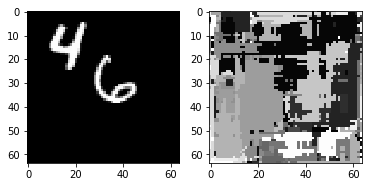

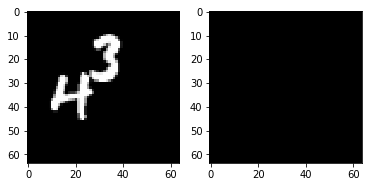

epoch=0; nll_tr=423.3757857; time_tr=95.6s;


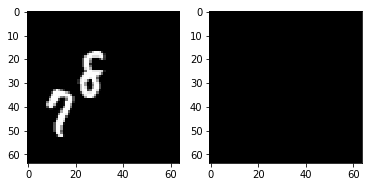

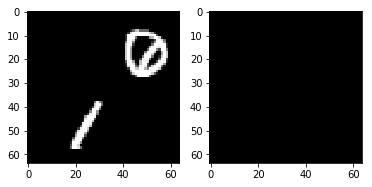

epoch=1; nll_tr=125.7597254; time_tr=104.4s;


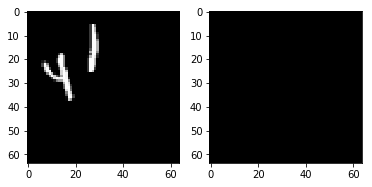

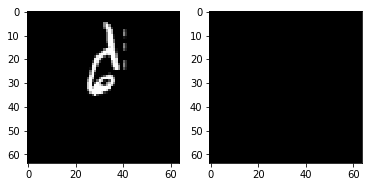

epoch=2; nll_tr=109.0378286; time_tr=106.6s;


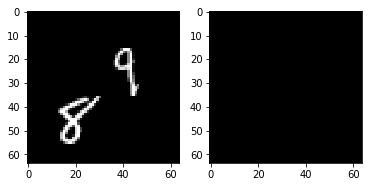

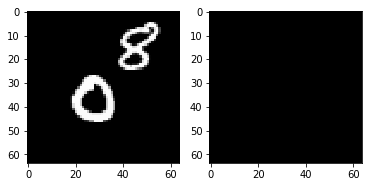

epoch=3; nll_tr=101.7563074; time_tr=106.9s;


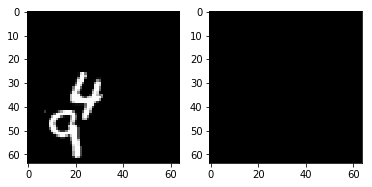

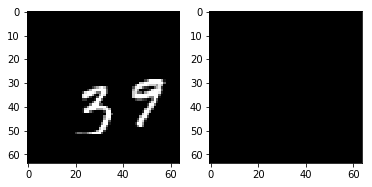

epoch=4; nll_tr=96.4349157; time_tr=106.3s;


In [23]:
losses = []
q_z = Normal(torch.tensor(0.).to(device), torch.tensor(1.).to(device))
for epoch in range(5):
    # train
    err_tr = []
    time_tr = time.time()
    curr_loss = []
    encoder.train(True)
    decoder.train(True)
    for idx, (x, y) in enumerate(train_loader):
        x = x.to(device) # range is negative to positive
        y = y.to(device).long()[:,0,:,:] * 255
        encoding_mu, encoding_logvar = encoder(x)
        encoding = encoder.rsample(encoding_mu, encoding_logvar)
        reconstruction = decoder(encoding)
        # Run it with the more complext PixelCNN using gates        
        # Try U-Net on Simple
        # VAE + Complex PixelCNN and U-Net        
        # Add loss term between z_image and input
        # Produce parameterhttp://localhost:8889/notebooks/vae-conv-only.ipynb#s from VAE for PixelCNN
#         px_given_z =   - Normal(reconstruction, 0.1).log_prob(data).sum() / x.shape[0]
#         kl = kl_divergence(encoding_logvar, encoding_mu) / x.shape[0]

        q_z_x = Normal(encoding_mu, (0.5 * encoding_logvar).exp())
        px_given_z = (F.cross_entropy(reconstruction, y, reduction='none') / x.shape[0]).sum()
        kl = (torch.distributions.kl.kl_divergence(q_z_x, q_z) / x.shape[0]).sum()
        loss = px_given_z +  kl
        curr_loss.append(loss.item())
        err_tr.append((px_given_z.item(), kl.item()))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if idx % 400 == 0:
            plt.figure()
            plt.subplot(1,2,1)
            imshow(x[0].view(64,64).detach(), cmap='gray')
            plt.subplot(1,2,2)
            imshow(reconstruction[0].argmax(dim=0).view(64,64).detach(), cmap='gray')
            plt.show()
    losses.extend(err_tr)
    time_tr = time.time() - time_tr
    print('epoch={}; nll_tr={:.7f}; time_tr={:.1f}s;'.format(
        epoch, np.mean(curr_loss), time_tr))



In [25]:
y.shape, reconstruction.shape

(torch.Size([96, 64, 64]), torch.Size([96, 256, 64, 64]))

In [26]:
encoder.eval()
decoder.eval()
for idx, (x, y) in enumerate(test_loader):
    x = x.to(device) # range is negative to positive
    y = y.to(device).long()[:,0,:,:] * 255
    encoding_mu, encoding_logvar = encoder(x)
    encoding = encoder.rsample(encoding_mu, encoding_logvar)
    reconstruction = decoder(encoding)
    break

In [63]:
output_ = torch.zeros(x.shape)
probs = F.softmax(reconstruction, dim=1)
for i in range(28):
    for j in range(28):
        output_[:, :, i,j] = torch.multinomial(probs[:, :, i, j], 1).float()

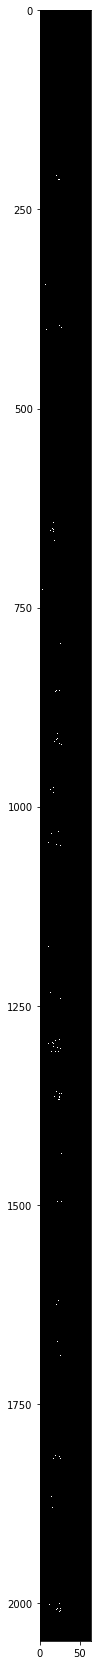

In [68]:
plt.figure(figsize=(1,30))
imshow(output_.view(-1,64), cmap='gray')